In [ ]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from google.colab import files
import zipfile
import random
import glob
import matplotlib.pyplot as plt

In [6]:
def get_image_annotation_pairs(image_dir, label_dir):
    annotations = {}
    image_files = glob.glob(os.path.join(image_dir, '**/*.jpg'), recursive=True)
    for img_path in image_files:
        label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
            bboxes = []
            for line in lines:
                parts = list(map(float, line.strip().split()))
                if len(parts) == 5:
                    class_id, x_center, y_center, w, h = parts
                    if w > 0.01 and h > 0.01:
                        bboxes.append([class_id, x_center, y_center, w, h])
            if bboxes:
                annotations[img_path] = bboxes
    return annotations

image_dir = 'wider_face_yolo/images'
label_dir = 'wider_face_yolo/labels'
annotations = get_image_annotation_pairs(image_dir, label_dir)

image_list = list(annotations.keys())
image_list = random.sample(image_list, min(10000, len(image_list)))

train_images, val_images = train_test_split(image_list, test_size=0.2, random_state=42)

print(f"Training images: {len(train_images)}, Validation images: {len(val_images)}")



Training images: 8000, Validation images: 2000


In [7]:
class WiderYOLODataset(Dataset):
    def __init__(self, image_list, annotations, S=7, B=2, C=1, transform=None):
        self.image_list = image_list
        self.annotations = annotations
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = self.image_list[idx]
        image = Image.open(img_path).convert('RGB')
        bboxes = self.annotations[img_path]
        w_img, h_img = image.size

        label_matrix = torch.zeros((self.S, self.S, self.C + self.B * 5))

        cells = [[[] for _ in range(self.S)] for _ in range(self.S)]
        for box in bboxes:
            _, x_center, y_center, w, h = box
            grid_x = int(x_center * self.S)
            grid_y = int(y_center * self.S)
            if 0 <= grid_x < self.S and 0 <= grid_y < self.S:
                cells[grid_y][grid_x].append((x_center, y_center, w, h))

        for gy in range(self.S):
            for gx in range(self.S):
                if cells[gy][gx]:
                    areas = [w * h for _, _, w, h in cells[gy][gx]]
                    max_idx = areas.index(max(areas))
                    cx, cy, w, h = cells[gy][gx][max_idx]
                    x_rel = cx * self.S - gx
                    y_rel = cy * self.S - gy
                    label_matrix[gy, gx, 0] = 1
                    for b in range(self.B):
                        label_matrix[gy, gx, self.C + b * 5] = 1
                        label_matrix[gy, gx, self.C + b * 5 + 1] = x_rel
                        label_matrix[gy, gx, self.C + b * 5 + 2] = y_rel
                        label_matrix[gy, gx, self.C + b * 5 + 3] = w ** 0.5
                        label_matrix[gy, gx, self.C + b * 5 + 4] = h ** 0.5

        if self.transform:
            image = self.transform(image)

        return image, label_matrix
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
])

train_dataset = WiderYOLODataset(train_images, annotations, transform=transform)
val_dataset = WiderYOLODataset(val_images, annotations, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [8]:
class YOLOv1(nn.Module):
    def __init__(self, S=7, B=2, C=1):
        super(YOLOv1, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3), nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 192, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(192, 128, 1), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 256, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 256, 1), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, 2),
            *[item for _ in range(4) for item in [nn.Conv2d(512, 256, 1), nn.LeakyReLU(0.1, inplace=True),
                                                  nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.1, inplace=True)]],
            nn.Conv2d(512, 512, 1), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, 2),
            *[item for _ in range(2) for item in [nn.Conv2d(1024, 512, 1), nn.LeakyReLU(0.1, inplace=True),
                                                  nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True)]],
            nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, 3, stride=2, padding=1), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * 7 * 7, 4096),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, S * S * (C + B * 5)),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = x.reshape(-1, self.S, self.S, self.C + self.B * 5)
        return x


In [9]:
class YOLOv1Loss(nn.Module):
    def __init__(self, S=7, B=2, C=1, lambda_coord=5.0, lambda_noobj=0.5):
        super().__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse = nn.MSELoss(reduction='sum')

    def forward(self, pred, target):
        batch_size = pred.size(0)
        coord_mask = (target[..., self.C] == 1).unsqueeze(-1).expand(-1, -1, -1, self.C + self.B * 5)
        noobj_mask = ~coord_mask[..., self.C].unsqueeze(-1)

        class_pred = pred[..., :self.C]
        class_target = target[..., :self.C]
        class_loss = self.mse(class_pred[coord_mask[..., :self.C]], class_target[coord_mask[..., :self.C]]) / batch_size

        device = pred.device
        grid_x = torch.arange(self.S, device=device).repeat(self.S, 1).view([1, self.S, self.S])
        grid_y = grid_x.transpose(1, 2)

        gt_x = target[..., self.C + 1]
        gt_y = target[..., self.C + 2]
        gt_w_sqrt = target[..., self.C + 3]
        gt_h_sqrt = target[..., self.C + 4]
        gt_w = gt_w_sqrt ** 2
        gt_h = gt_h_sqrt ** 2
        gt_cx = (grid_x + gt_x) / self.S
        gt_cy = (grid_y + gt_y) / self.S
        gt_boxes = torch.stack([gt_cx, gt_cy, gt_w, gt_h], dim=-1)

        box_loss = 0
        conf_obj_loss = 0
        conf_noobj_loss = 0
        ious = []
        pred_confs = []

        for b in range(self.B):
            offset = self.C + b * 5
            pred_conf = torch.sigmoid(pred[..., offset])
            pred_x = torch.sigmoid(pred[..., offset + 1])
            pred_y = torch.sigmoid(pred[..., offset + 2])
            pred_w_sqrt = pred[..., offset + 3]
            pred_h_sqrt = pred[..., offset + 4]
            pred_w = pred_w_sqrt ** 2
            pred_h = pred_h_sqrt ** 2
            pred_cx = (grid_x + pred_x) / self.S
            pred_cy = (grid_y + pred_y) / self.S
            pred_boxes = torch.stack([pred_cx, pred_cy, pred_w, pred_h], dim=-1)

            i_xmax = torch.min(pred_boxes[..., 0] + pred_boxes[..., 2] / 2, gt_boxes[..., 0] + gt_boxes[..., 2] / 2)
            i_xmin = torch.max(pred_boxes[..., 0] - pred_boxes[..., 2] / 2, gt_boxes[..., 0] - gt_boxes[..., 2] / 2)
            i_ymax = torch.min(pred_boxes[..., 1] + pred_boxes[..., 3] / 2, gt_boxes[..., 1] + gt_boxes[..., 3] / 2)
            i_ymin = torch.max(pred_boxes[..., 1] - pred_boxes[..., 3] / 2, gt_boxes[..., 1] - gt_boxes[..., 3] / 2)
            inter = (i_xmax - i_xmin).clamp(0) * (i_ymax - i_ymin).clamp(0)
            union = pred_boxes[..., 2] * pred_boxes[..., 3] + gt_boxes[..., 2] * gt_boxes[..., 3] - inter
            iou = inter / (union + 1e-6)
            ious.append(iou)

            pred_confs.append(pred_conf)

            box_x_loss = (pred_x - gt_x) ** 2
            box_y_loss = (pred_y - gt_y) ** 2
            box_w_loss = (pred_w_sqrt - gt_w_sqrt) ** 2
            box_h_loss = (pred_h_sqrt - gt_h_sqrt) ** 2
            box_b_loss = (box_x_loss + box_y_loss + box_w_loss + box_h_loss) / batch_size * self.lambda_coord

        ious = torch.stack(ious, dim=-1)
        max_iou, resp_b = torch.max(ious, dim=-1, keepdim=True)


        resp_mask = torch.zeros_like(ious)
        resp_mask.scatter_(-1, resp_b, 1)
        resp_coord_mask = resp_mask * coord_mask[..., self.C:self.C + self.B * 5].view(batch_size, self.S, self.S, self.B, 5)[..., 0]
        box_loss = (box_b_loss * resp_coord_mask.sum(-1)).sum()

        pred_confs = torch.stack(pred_confs, dim=-1)
        conf_obj_delta = pred_confs * resp_mask
        conf_obj_target = max_iou * resp_mask
        conf_obj_loss = self.mse(conf_obj_delta[coord_mask[..., self.C].unsqueeze(-1).expand(-1, -1, -1, self.B)],
                                 conf_obj_target[coord_mask[..., self.C].unsqueeze(-1).expand(-1, -1, -1, self.B)]) / batch_size

        non_resp_mask = (1 - resp_mask) * coord_mask[..., self.C].unsqueeze(-1)
        conf_noobj_obj = (pred_confs ** 2) * non_resp_mask
        conf_noobj_noobj = (pred_confs ** 2) * noobj_mask.expand(-1, -1, -1, self.B)
        conf_noobj_loss = (conf_noobj_obj + conf_noobj_noobj).sum() / batch_size * self.lambda_noobj

        total_loss = class_loss + box_loss + conf_obj_loss + conf_noobj_loss
        return total_loss

Epoch [1/10], Train Loss: 8.4771, Val Loss: 4.4964
Epoch [2/10], Train Loss: 4.7300, Val Loss: 4.4892
Epoch [3/10], Train Loss: 4.5916, Val Loss: 4.4160
Epoch [4/10], Train Loss: 4.5252, Val Loss: 4.3501
Epoch [5/10], Train Loss: 4.4906, Val Loss: 4.3252
Epoch [6/10], Train Loss: 4.4680, Val Loss: 4.3226
Epoch [7/10], Train Loss: 4.4381, Val Loss: 4.3105
Epoch [8/10], Train Loss: 4.4272, Val Loss: 4.3079
Epoch [9/10], Train Loss: 4.4122, Val Loss: 4.2819
Epoch [10/10], Train Loss: 4.4046, Val Loss: 4.2862


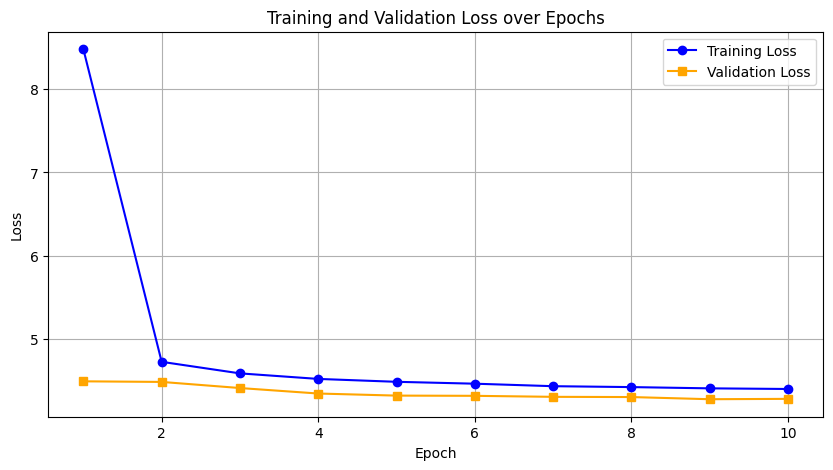

In [10]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = YOLOv1().to(device)
criterion = YOLOv1Loss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)


num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


